# Introduction

This project is an extension of some work I did assisting a friend taking a class on Data Analysis in Python, and it was done strictly for my own learning in my personal time. While the class's focus was on a project based approach to learning the data analysis process, through assisting my friend, I started to gain a deeper insight into the data and found it to be very amenable to exploration. 

This analysis aims to examine if there is a relationship between measures of a nursing home's quality, and their COVID mortality rates. The pandemic not only caused a great shift in our relationship to public institutions, but also exposed fundamental flaws in the way that the structures in place attempt to protect the general population from exigent circumstances. Nowhere is this phenomenon more evident than in our country's most medically vulnerable populations (e.g. the immunocompromised and the elderly).

The datasets used in this project are all centered in Minnesota, and track both elder care provider information as well as COVID patient outcomes in said nursing homes. All credit goes to my friend for providing both the data sets as well as the data dictionaries for all raw data used in this project, and this would not have been possible without them.

First, this analysis will describe the data cleaning and extraction process utilized to yield an appropriate subset for analysis. Then, an OLS, Quadratic Regression, and an ANOVA test will be conducted to see if there is a statistically significant metric that can demonstrate and describe the relationship between measures of a nursing home's quality and its COVID mortality outcomes. I got both a needed refresher of the basics as well as learned a lot of new things during the course of this project, and am definitely planning to come back to it in the future to improve it in all aspects.


## Data Extraction and Preparation

### Importing Libraries and the Data

The first step is to import the necessary libraries used during this analysis. The first few libraries are the standard scientific computing packages used in basic regressions and data manipulation (e.g. pandas, numpy, sklearn). The linear model package is imported to conduct the OLS and Quadratic Regressions, and seaborn is imported to visualize any metrics/data. Finally, the statsmodels package is used to have a quick way to visualize model performance metrics, as well as provide an alternative method to conduct an OLS.


In [1]:
#Import libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from statsmodels.stats.stattools import durbin_watson as dwtest
import sklearn.metrics

The code below is used to import the data sets, which are locally stored on my computer.

In [2]:
%%capture
#Import Data Sets
provider_info = pd.read_excel('ProviderInfo_MN_Mar2020.xlsx')
covid_data = pd.read_csv('Nursing_Home_Data.csv')

### Cleaning up the Covid Data 

The first step in my workflow was to clean both individual data sets, and then merge them into a single dataframe with all of the extraneous columns removed. I started with the COVID mortality dataset, which tracks COVID patient outcomes across various nursing facilities. The code below subsets the larger data frames into only including the timeframe, provider number, weekly deaths and total deaths columns. To aid in subsequent filtering operations, I enforced the datetime type onto the week_end column and then dropped any rows with empty entries, making sure the integrity of the data was preserved by not removing too many entries.



In [3]:
#select the week, provider id, and weekly covid deaths columns
filtered_covid_data = covid_data[['Week Ending','Federal Provider Number', 'Weekly Resident COVID-19 Deaths Per 1,000 Residents',
                                  'Residents Total COVID-19 Deaths']].copy()
#rename the columns to make them shorter and eliminate white spaces
filtered_covid_data.rename(columns={'Week Ending': 'week_end', 'Federal Provider Number': 'provider_number', 'Weekly Resident COVID-19 Deaths Per 1,000 Residents' : 'weekly_deaths',
                                    'Residents Total COVID-19 Deaths': 'total_deaths'}, inplace=True)
#convert the week column into datetime type
filtered_covid_data['week_end'] = pd.to_datetime(filtered_covid_data['week_end'])
filtered_covid_data.dropna()
#display the dataframe
filtered_covid_data.head()

,week_end,provider_number,weekly_deaths,total_deaths
0,2020-05-24,15009,88.89,4.0
1,2020-05-31,15009,0.00,4.0
2,2020-06-07,15009,0.00,4.0
3,2020-06-14,15009,0.00,4.0
4,2020-06-21,15009,0.00,4.0


Displaying the filtered data frame at the end shows that the relevant columns have been successfully extracted and renamed. Just for additional verification, I made sure to check the data types of all extracted columns to verify that the type enforcement above worked successfully.

In [4]:
# Check Data types of covid df
filtered_covid_data.dtypes

week_end           datetime64[ns]
provider_number            object
weekly_deaths             float64
total_deaths              float64
dtype: object

### Cleaning up the Provider Data

The process for the Provider data is relatively similar to the COVID data. The only notable difference was that specifying the dtype on import for the Weighted Survey Score column raised some errors, so I ended up converting the column to a numeric type later, and coercing errors to place NaN's wherever there was a problematic entry. Just like the COVID data, for ease of use, I dropped all rows with NaNs in the weighted score or quality rating columns. Our merging performed in the next step will ensure that all rows are matched correctly anyways, and the inner join will exclude entries from the merged DataFrame that were dropped from the provider DataFrame.


In [5]:
#select the provider ID and quality rating columns from provider dataset
filtered_prov_data = provider_info[['PROVNUM','Quality_Rating','WEIGHTED_ALL_CYCLES_SCORE']].copy()
#renaming columns for consistency
filtered_prov_data.rename(columns={'PROVNUM': 'provider_number','Quality_Rating': 'quality_rating','WEIGHTED_ALL_CYCLES_SCORE':'weighted_score'}, inplace=True)
#display the dataframe
filtered_prov_data['weighted_score'] = pd.to_numeric(filtered_prov_data['weighted_score'], errors='coerce')
filtered_prov_data.dropna()
filtered_prov_data.head()

,provider_number,quality_rating,weighted_score
0,15009,5.0,5.333
1,15010,4.0,18.667
2,15012,2.0,30.667
3,15014,1.0,24.667
4,15015,4.0,14.000


Once again, the renaming and type enforcement appears to have been successful. Since the provider_number column will mainly be used for the merging, its object typing in both DataFrames is not relevant, as in the merging step I can verify that the appropriate matching has occurred.

In [6]:
filtered_prov_data.dtypes

provider_number     object
quality_rating     float64
weighted_score     float64
dtype: object

### Filtering to June 2020 Data

To avoid covariance and multicollinearity arising due to improper handling of the temporal elements in the data, I decided to focus on a single month for ease of analysis. This lets me direct more effort on exploring the data and fine tuning the linear model without having to worry about violating any model assumptions due to not handling the time series correctly. The code below creates a boolean mask and filter to only extract rows that have been recorded in June of 2020.


In [7]:
#filter covid data to include only June 2020 rows
june_data = filtered_covid_data[filtered_covid_data['week_end'].dt.month == 6]
june_data = june_data[june_data['week_end'].dt.year == 2020]
#display the dataframe
june_data.head()

,week_end,provider_number,weekly_deaths,total_deaths
2,2020-06-07,15009,0.0,4.0
3,2020-06-14,15009,0.0,4.0
4,2020-06-21,15009,0.0,4.0
5,2020-06-28,15009,0.0,4.0
109,2020-06-07,15010,0.0,0.0


In [8]:
june_data.shape

(39464, 4)

Displaying the head and shape shows that we have now cut our DataFrame down by a few rows. However, as we can see, each provider was surveyed and tracked multiple times a month, so in order to create a DataFrame that makes sense for the statistical models I have in mind, I decided to quickly aggregate the tracked statistics by Provider, and just used the intuitive aggregations that made sense for our analysis. Essentially all this means is that I aggregated the sum value for the weekly deaths column, and the max value for the total deaths column.

In [9]:
#aggregate data by sum of weekly deaths in June 2020 grouped by provider ID
new_june = june_data.groupby(['provider_number']).agg({'weekly_deaths':sum}).sort_values(by = 'weekly_deaths', ascending=False )
new_june.head()
test = june_data.groupby(['provider_number']).agg({'weekly_deaths':sum}).sort_values(by = 'weekly_deaths', ascending=False )

Finally, I performed an inner join with our June Covid Data, and our Provider Survey info to get a singular DataFrame that includes the June Summary Statistics for COVID mortality rates, as well as the quality ratings and weighted quality survey scores of each provider. Just to make sure that we have all numeric values in our aggregated DataFrame, I dropped any nulls or NaN's found in the merged DataFrame for ease of analysis down the line.

In [10]:
#join both data frames to include quality rating
merge = new_june.merge(filtered_prov_data, on = 'provider_number')
#sort by weekly deaths to confirm there are non-zero entries in our dataframe
merge.sort_values(by='weekly_deaths', ascending=False)
#drop rows that are non numeric values for weekly deaths
merge = merge.dropna()
merge.head()

,provider_number,weekly_deaths,quality_rating,weighted_score
0,155389,1236.53,5.0,70.000
1,55341,1166.67,4.0,82.000
2,215278.0,1000.00,5.0,14.667
3,335618,898.53,3.0,10.000
4,255262,822.52,2.0,65.167


In [11]:
#check for NAN values if not dropped
merge['quality_rating'].isnull().sum()
merge[merge['quality_rating'].isna()]
merge = merge.loc[~((merge['weekly_deaths'] == 0))]

## The Linear Model

As we will see later, the distribution of the data points we are going to use does not necessarily indicate that the relationship between our independent and dependent variables are linear, however I still wanted to practice setting up and conducting an OLS, and was also simply curious to see how many assumptions of the test would be satisfied with this data.

As a short recap, our OLS (ordinary least squares) regression is a method for choosing our unknown parameters in a linear regression model. Essentially, assume the relationship between our variables is of the form:

$$ y = X\beta + \epsilon $$

Conducting an OLS gives us a means of choosing our optimal value for the X parameter, that is the ideal X is that which minimizes the sum of the squared values of our residuals (residuals being the difference between our predicted outcome and our observed outcome). Typically we should check that the following assumptions are satisfied when determining whether or not to use an OLS:

1. Linearity - Are the relationships between our variables linear? As we will see from the scatterplot, this is most likely not the case, but for the sake of practice we can assume so.
2. Error terms must be normally distributed - This is fairly self explanatory, and just as with the previous assumption this is probably not going to be the case.
3. No Multicollinearity amongst predictors - When using more than one independent variable, are any two or more of your explanatory variables linearly related or dependent? In this case, I am going to utilize only one predictor in this OLS so for now this won't be an issue. 
4. No autocorrelation of error terms - Autocorrelation is the degree of relationship between the error terms in our linear model. To test this, we can use Durbin-Watson test to detect systemic biases
5. Homoscedasticity - Is the variance with our error terms constant? To examine this, we can plot our error terms and see how they are distributed around the zero line.

Finally, since our Linear Model requires an analysis between two continuous variables, the dependent variable in this case will be the average weekly deaths per month in a care facility, and the dependent variable will be a weighted survey score assessing the quality of care provided in that facility.


### Checking Assumptions: Cleaning up the data

Due to the uneven distribution and large amount of data points, attempting to examine the visual relationship between our two variables seems difficult at first glance. For example, take the scatterplot below:


In [82]:
sns.set_style("darkgrid")

[Text(0.5, 0, 'Weighted Quality Score'),
 Text(0, 0.5, 'Average Weekly Deaths'),
 Text(0.5, 1.0, 'Average Weekly COVID Deaths vs. Weighted Quality Scores')]

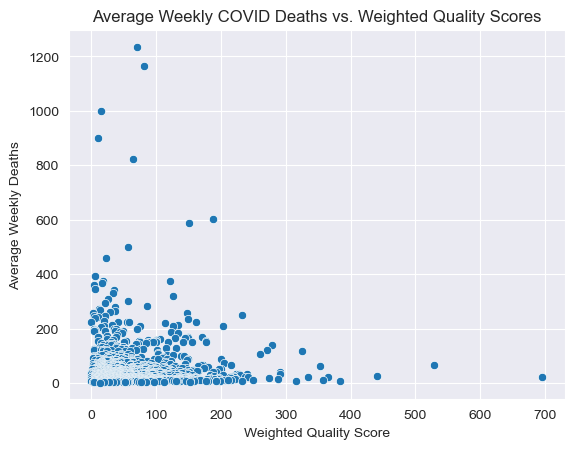

In [83]:
sns.scatterplot(data = merge, x = 'weighted_score',y='weekly_deaths').set(xlabel = 'Weighted Quality Score', ylabel = 'Average Weekly Deaths', title = 'Average Weekly COVID Deaths vs. Weighted Quality Scores')

It definitely looks like our data is a bit right skewed when it comes to the distribution of our dependent variable. Looking at a boxplot of our weekly_deaths confirms this.

[Text(0.5, 0, 'Weekly Deaths'),
 Text(0.5, 1.0, 'Distribution of Weekly Deaths')]

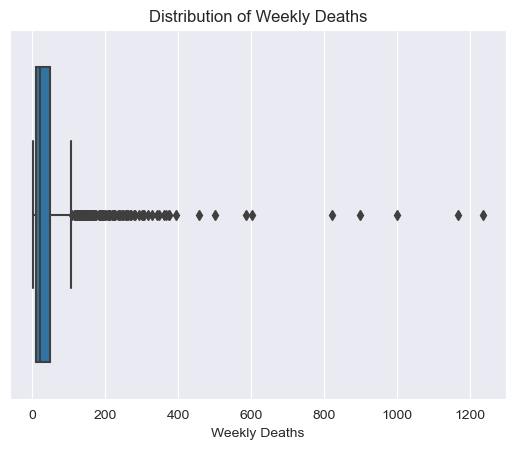

In [70]:
sns.boxplot(x=merge['weekly_deaths']).set(xlabel = 'Weekly Deaths', title = 'Distribution of Weekly Deaths')

Due to the presence of outliers, as well as the lack of axes bounding, it becomes hard to take a closer look at the bulk of the data and examine how the data points are distributed. The first problem I tackled was to eliminate outliers. There are many ways to go about doing this, but I ended up just using the IQR interval to eliminate entries outside the range of the 1.5 * the Quartile. This was just the simplest and quickest way for me to get a closer look at the relevant section of the data. 

In [42]:
#Eliminating outliers using IQR from the data frame
to_clear = merge.copy()

Q1=to_clear['weekly_deaths'].quantile(0.25)
Q3=to_clear['weekly_deaths'].quantile(0.75)
IQR=Q3-Q1

#remove outliers using IQR
cleared_IQR = to_clear.loc[(to_clear['weekly_deaths'] >= (Q1 - 1.5*IQR)) & (to_clear['weekly_deaths'] <= (Q3+1.5*IQR))]
cleared_IQR

,provider_number,weekly_deaths,quality_rating,weighted_score
138,145724,106.67,5.0,45.333
139,145532,106.60,2.0,56.000
140,245324,106.38,3.0,260.333
141,325058,106.11,3.0,102.667
142,115334,105.98,3.0,20.667
...,...,...,...,...
1504,315249,2.48,5.0,15.333
1505,335334,2.33,5.0,77.333
1506,335100,2.03,5.0,27.333
1507,335063.0,2.01,5.0,20.000


Now, taking a scatterplot of our modified data set seems to indicate a clearer picture of how the locus of the data points are distributed. Again, it doesn't seem like there is a strongly linear relationship between our two variables, but for the purposes of practice, I went ahead and conducted an OLS anyway. Our first assumption has been tested.

[(9.0, 125.0),
 Text(0.5, 0, 'Weighted Quality Score'),
 Text(0, 0.5, 'Weekly Deaths'),
 Text(0.5, 1.0, 'Weekly Deaths vs. Weighted Quality Scores')]

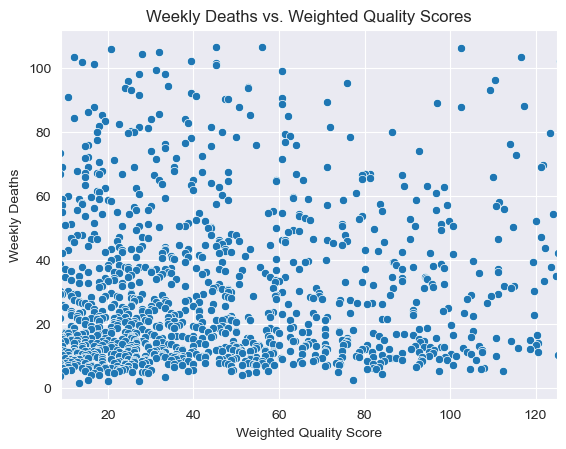

In [72]:
sns.scatterplot(x=cleared_IQR['weighted_score'],y=cleared_IQR['weekly_deaths']).set(xlim=(9,125), xlabel = 'Weighted Quality Score', ylabel = 'Weekly Deaths', title = 'Weekly Deaths vs. Weighted Quality Scores')

Just out of curiosity, I also wanted to examine the distribution of our dependent variable. While not a perfect normal distribution, I was surprised to see the general unimodal distribution of our weekly deaths statistic. I was not surprised to see that our data was still right skewed, however, it definitely is not as skewed as it was prior to our outlier removal.

[Text(0.5, 0, 'Weekly Deaths'),
 Text(0.5, 1.0, 'Distribution of Weekly Deaths')]

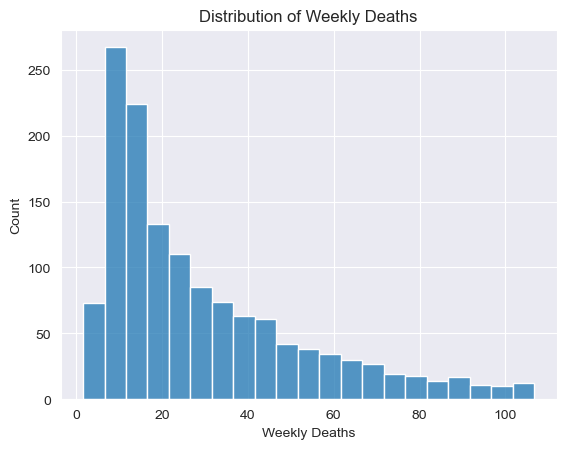

In [73]:
sns.histplot(cleared_IQR['weekly_deaths']).set(xlabel = 'Weekly Deaths', title = "Distribution of Weekly Deaths")

### Building the model

All the other assumptions listed above would need to be tested after the Linear Model was constructed. After some light exploratory data analysis, the first step in preparing the model was to split the DataFrame into a training set and testing set. I did this through sklearns built-in train_test_split method, with a test_size of 0.33 and a random seed of 42.


In [45]:
#split the dataframe into testing and training set
x_train, x_test, y_train, y_test = train_test_split(cleared_IQR['weighted_score'], cleared_IQR['weekly_deaths'], test_size=0.33, random_state=42)


Then, since sklearn’s LinearRegression object requires a 2D array (or matrix) as an input to its fit function, I quickly reshaped the x_train vector, and then simply passed it into an instantiated LinearRegression object.

In [46]:
%%capture
#reshape our x variable vector
x_train_reshaped = x_train.values.reshape((-1,1))
y = y_train
#fit the model using our variable vectors
sklearn_OLS = LinearRegression()
sklearn_OLS.fit(x_train_reshaped,y)

Once the model has been fitted, we can run our model on the testing set to evaluate its performance. After, we can take a peek into the model statistics below by extracting the r-squared value, intercept, and coefficient values.

In [47]:
#reshape our x_test values
copy_x = x_test.copy()
x_test_reshaped = x_test.values.reshape((-1,1))
#store our observed values
expected = y_test
#obtain our vector of predicted values
predicted = sklearn_OLS.predict(x_test_reshaped)

In [48]:
# model stats

# Obtain the coefficient of determination by calling the model with the score() function, then print the coefficient:
r_sq = sklearn_OLS.score(x_train_reshaped, y_train)
print('coefficient of determination:', r_sq)

# Print the Intercept:
print('intercept:', sklearn_OLS.intercept_)

# Print the Slope:
print('slope:', sklearn_OLS.coef_)

coefficient of determination: 0.00026355605981265295
intercept: 29.287922844165152
slope: [0.00640379]


In [106]:
sk_ols_stats = [["Coefficient of Determination",r_sq],["Intercept", sklearn_OLS.intercept_],["Coefficient",sklearn_OLS.coef_]]
sk_ols_stats = pd.DataFrame(sk_ols_stats, columns = ["Model Stats", " Value"]).style.hide(axis=0).set_properties(subset=['Model Stats'], **{'text-align':'left'})
sk_ols_stats

Model Stats,Value
Coefficient of Determination,0.000299
Intercept,29.287923
Coefficient,[0.00640379]


As expected, our model predicts a very weak linear relationship between weekly deaths and the quality score. However, to summarize our model’s analysis (on the training set), it indicates that for every 1 unit increase in our survey score, we can expect to observe a 0.006 unit increase in the weekly deaths experienced by that facility. If that seems counter-intuitive, it's because the conclusion it drew is probably wrong, due to the true nature of the relationship of the variables being non-linear. The r-squared value verifies this, as it comes in at a very low 0.00026. Only 0.026% of the variance in weekly deaths can be explained by our linear shift in our quality scores. We will still test the other assumptions for the sake of practice, but the conclusion for this analysis is that an OLS is not the appropriate method to describe the relationship between our variables.

In [49]:

r_sq = sklearn_OLS.score(x_test_reshaped, y_test)
print('coefficient of determination:', r_sq)

coefficient of determination: -0.0027617257919714255


An interesting note is that, while the r-squared value of our testing set is still low, it demonstrates the intuitive conclusion we would expect to see (i.e. an increase in quality is associated with a reduced COVID death statistic). However, the explanatory power of the model is still very low, and thus it confirms an OLS is not the appropriate model to use in this instance.

### Checking further Assumptions

#### Distribution of Errors

I now tested the rest of the assumptions outlined above. First was an examination of the distribution of the error term, i.e. the residuals. The code below uses the predicted and observed values in our testing set and examines their distribution.


[Text(0.5, 0, 'Residuals'), Text(0.5, 1.0, 'Distribution of Model Residuals')]

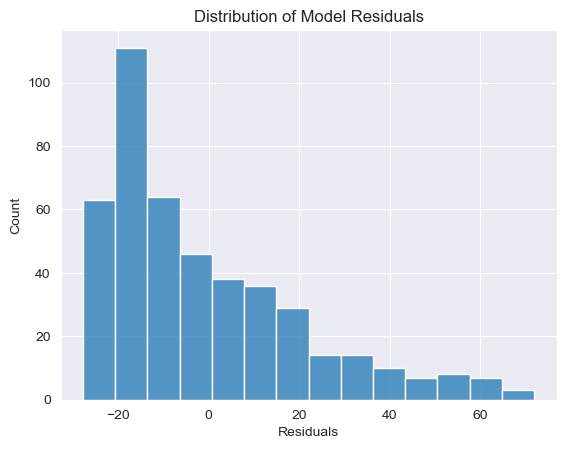

In [74]:
resid = (y_test - predicted)
sns.histplot(resid).set(xlabel = 'Residuals', title = "Distribution of Model Residuals")

While this data appears to follow a unimodal distribution, when taking an approximation of the variance, one can see that it is still far too right skewed to count as a normal distribution. Thus, I confirmed that our second assumption for an OLS was not met.


### Multicollinearity

As mentioned above, since a single variable OLS was used, I did not need to check if there was Multicollinearity amongst the independent variables.

### Autocorrelation

As stated above, I used the Durbin-Watson test to examine autocorrelation. The code below conducts the test.


In [51]:
#pass in the residual array to the dwtest function
dwtest(resids=resid)

1.9074846791414608

Our $d$ statistic is very close to 2, which indicates that there is evidence of non-autocorrelation. There is slight positive autocorrelation, however our OLS still seems to do a good job of satisfying this condition.

### Heteroscedasticity

The final assumption we must check is Heteroscedasticity, i.e. is the variance of our error terms constant. To do this, I made a scatterplot of our residuals against the x_test values.


[Text(0.5, 0, 'Weighted Quality Score'),
 Text(0, 0.5, 'Weekly Deaths'),
 Text(0.5, 1.0, 'Weekly Deaths vs. Weighted Quality Score')]

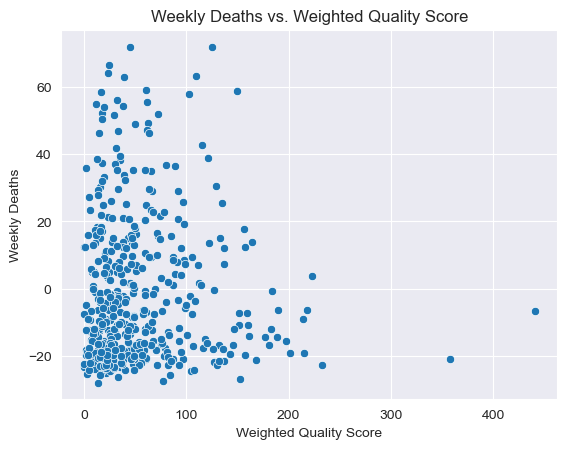

In [75]:
sns.scatterplot(x = copy_x, y = resid).set(xlabel = 'Weighted Quality Score', ylabel = 'Weekly Deaths', title = 'Weekly Deaths vs. Weighted Quality Score')

As expected, the variance of the error term is not constant. There is a non uniform distribution of the residuals around the zero line, and most residuals seem to be clustered in the (-20,0) range. While not surprising, it is confirmed that the final assumption of the OLS model has been violated.

## Linear Model Addendum : Using the Statsmodels package

The statsmodels package makes it easier to conduct more classical statistical analysis in python, and just out of curiosity I wanted to create a Linear Model using this package and compare its statistics to the sklearn model. First, I created a DataFrame by combining our training values so I can pass it into the OLS function. Then, this package's instantiation of the OLS is fairly straightforward, and the one line of code below is enough to instantiate and fit the model. 

In [53]:
#create the testing DataFrame to pass in
ols_testing_df = pd.DataFrame(
    {'x_train' : x_train,
    'y_train' : y_train}
)
#instantiate and fit the model
sm_ols_model = ols('y_train ~ x_train', data = ols_testing_df).fit()

Then, to get the necessary residual plots for verifying assumptions and evaluating performance, I applied the plot_regress_exog method, which quickly and neatly graphed the necessary regression plots. As we can see above, many of the OLS assumptions have been violated. Taking a look at the model statistics also indicates that our Linear Model has very low explanatory power as well. While no new information has necessarily been discovered, I decided to conduct the regression using this package as well just for additional practice.

eval_env: 1


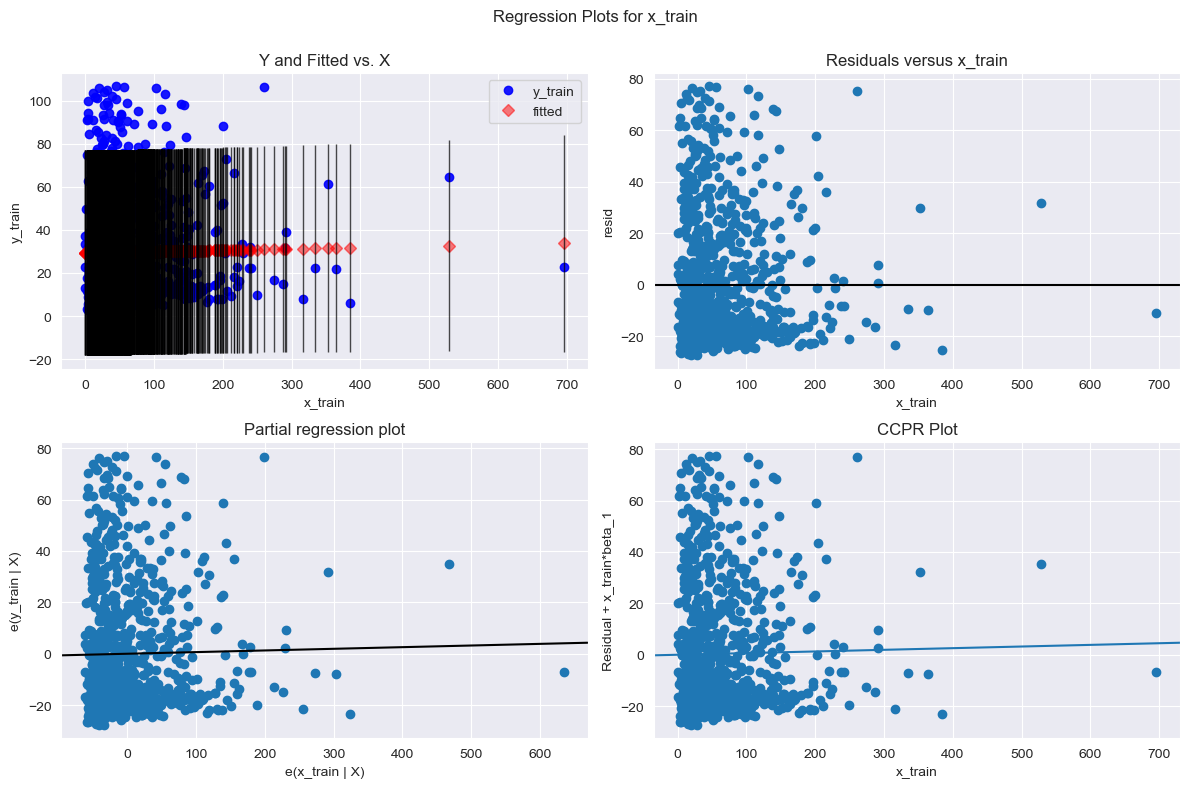

In [54]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(sm_ols_model, 'x_train', fig=fig)

In [55]:
print(sm_ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                y_train   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2399
Date:                Fri, 14 Apr 2023   Prob (F-statistic):              0.624
Time:                        13:38:44   Log-Likelihood:                -4200.5
No. Observations:                 912   AIC:                             8405.
Df Residuals:                     910   BIC:                             8415.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.2879      1.132     25.884      0.0

In the future I would like to do a more detailed comparison of the differences in accuracy between these two packages, however that is outside of the scope of this analysis and I would also use a better dataset when conducting the comparison of these two different models.


## Polynomial regression Model

Since the OLS did not work that well, I was curious if changing the method to a polynomial regression would work any better. Again, from the above scatterplot, it doesn't necessarily seem that the data follows a parabolic trend, but I thought it would be interesting to run a degree 2 polynomial regression and compare the results to the linear models constructed above. The first step is to construct the features that our Polynomial model will have, which in this case is simply enforcing that the regression has the form of a degree 2 polynomial.


In [56]:
#instantiate our polynomial features
poly_features = PolynomialFeatures(degree=2)
#convert our x_train into an array
x = np.array(x_train)
#fit_transforms reshapes our 1D array into a 2D array to be passed into the regression model
poly_features = poly_features.fit_transform(x.reshape(-1,1))

Then we can simply instantiate a linear regression object and pass in the polynomial features and dependent variable when fitting it.

In [57]:
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y_train)
y_predicted = poly_reg_model.predict(poly_features)

When looking at the line plot of our predicted values, we can see that the model clearly takes the form of a degree 2 polynomial.

[Text(0.5, 0, 'Weighted Quality Score'),
 Text(0, 0.5, 'Weekly Deaths'),
 Text(0.5, 1.0, 'Model Predictions of Weekly Deaths vs. Weighted Quality Score')]

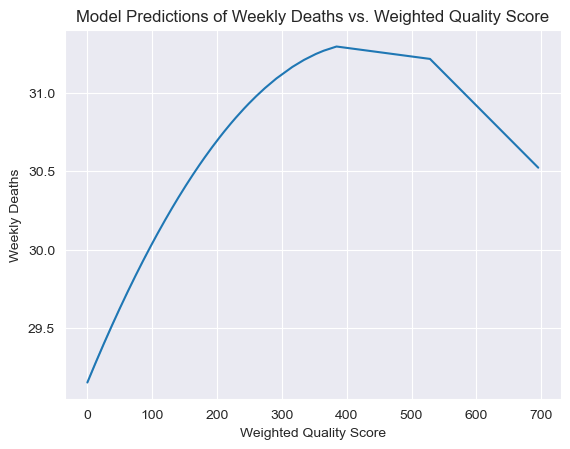

In [76]:
sns.lineplot(x = x, y = y_predicted).set(xlabel= 'Weighted Quality Score', ylabel = 'Weekly Deaths', title = "Model Predictions of Weekly Deaths vs. Weighted Quality Score")

However, when looking at the trend line in the context of the overall data, again it becomes evident that a polynomial regression is not that appropriate either.

Text(0.5, 0.98, 'Model Predictions vs. Observed Distribution of Training Set')

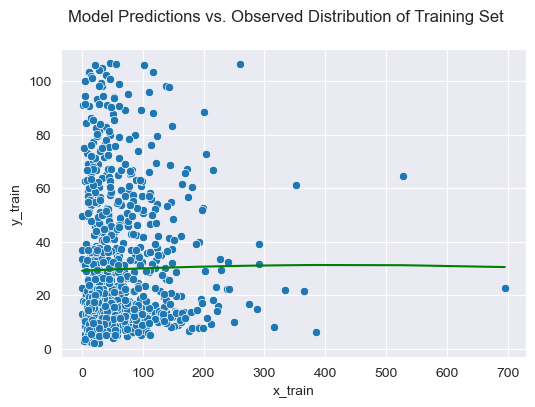

In [77]:
quad_graph_df = pd.DataFrame(
    {'x_train' : x_train,
    'y_train' : y_train,
    'y_pred':y_predicted}
)
fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.scatterplot(data=quad_graph_df, x='x_train', y='y_train', ax=ax)
p2 = sns.lineplot(data=quad_graph_df, x='x_train', y='y_pred', color='g', ax=ax)
fig.suptitle('Model Predictions vs. Observed Distribution of Training Set')

In [60]:
r_sq = sklearn.metrics.r2_score(y_true = y_train, y_pred = quad_graph_df['y_pred'])
print('coefficient of determination:', r_sq)

# Print the Intercept:
print('intercept:', poly_reg_model.intercept_)

# Print the Coefficients:
print('slope:', poly_reg_model.coef_)

coefficient of determination: 0.00029919516372389765
intercept: 29.154150886109186
slope: [ 0.00000000e+00  1.00181241e-02 -1.15750081e-05]


In [104]:
table = [["Coefficient of Determination",r_sq],["intercept",poly_reg_model.intercept_],["Coefs",poly_reg_model.coef_]]
poly_model_stats = pd.DataFrame(table,columns=['Model stats', "Value"]).style.hide(axis = 0)
poly_model_stats.set_properties(subset=['Model stats'], **{'text-align': 'left'})
poly_model_stats

Model stats,Value
Coefficient of Determination,0.000299
intercept,29.154151
Coefs,[ 0.00000000e+00 1.00181241e-02 -1.15750081e-05]


The poor explanatory power of the model is confirmed by the model statistics. Only 0.03 percent of the variation in weekly deaths can be explained by a change in the quality survey score in our model. Also according to this model we would expect a facility with a quality score of 0 to have an average death rate of 29.154 patients per month. After investing these two linear models, I will end the analysis by investing a final approach, using an ANOVA test to examine the relationship between our continuous dependent variable and a categorical independent variable.

## ANOVA test

An ANOVA test is a popular statistical test used to examine the relationship between a continuous dependent variable and a categorical independent variable. Simplified, it essentially involves comparing if there is a statistically significant difference in means across various subsets of our population (the subsets in this case being the categorical quality rating). Like the previous section, I will begin by transforming our original merged DataFrame into the two columns we need, and then conduct the test from there.

### Model Assumptions

An Anova test has the following assumptions

Random and independent samples must be taken from the population
Normality - The distribution of weekly deaths (dependent variable) in each group is normally distributed. We can check this using a Q-Q plot
Homogeneity of Variance - The ratio of the largest to smallest subset standard deviation must be less than 2

In the subsequent sections, I will test these assumptions one by one.


### Random Samples

The below code takes a random sample of size 1000 from our population dataset. The code below enforces the numeric type on the unique provider ID’’s, and then randomly selects 1000 provider ID’s to be used in the sample. The larger DataFrame is then filtered to include only the 1000 provider ID’s randomly selected. The code also guarantees that the samples are taken independently. 


In [61]:
import random
unique_provider_nums = pd.to_numeric(merge['provider_number'],errors='coerce')
unique_provider_nums = unique_provider_nums.unique()
unique_provider_nums = unique_provider_nums[~np.isnan(unique_provider_nums)]
random.seed(42)
sample_nums = random.sample(list(unique_provider_nums),1000)

sample_df = merge[merge['provider_number'].isin(sample_nums)].reset_index(drop=True)
sample_df = sample_df[['quality_rating','weekly_deaths']]
sample_df.head()

,quality_rating,weekly_deaths
0,5.0,1236.53
1,4.0,1166.67
2,5.0,1000.00
3,3.0,898.53
4,2.0,822.52


Just to get an idea of the counts, I quickly did a summary table of the number of entries per category of quality rating.

In [62]:
groups = sample_df.groupby('quality_rating').count().reset_index()
groups

,quality_rating,weekly_deaths
0,1.0,50
1,2.0,144
2,3.0,197
3,4.0,276
4,5.0,333


### Normality 

The following code isolates each unique value for the quality rating and generates a Q-Q plot to gauge the normality of the distribution within each subset of the data. As long as the data points are relatively following the trend line, then we can assume that our samp[le satisfies the assumption. In this case, we can conclude that each subsets distribution is relatively normal.


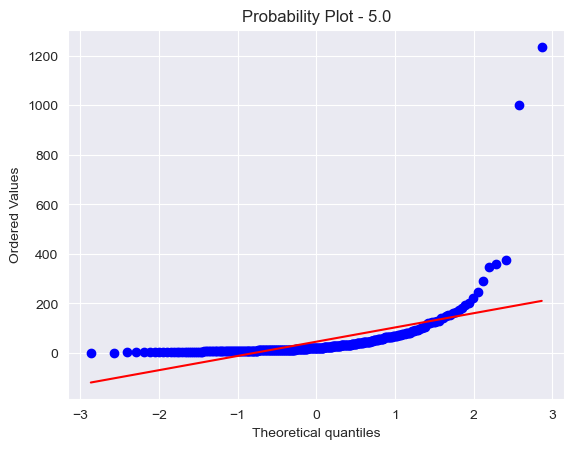

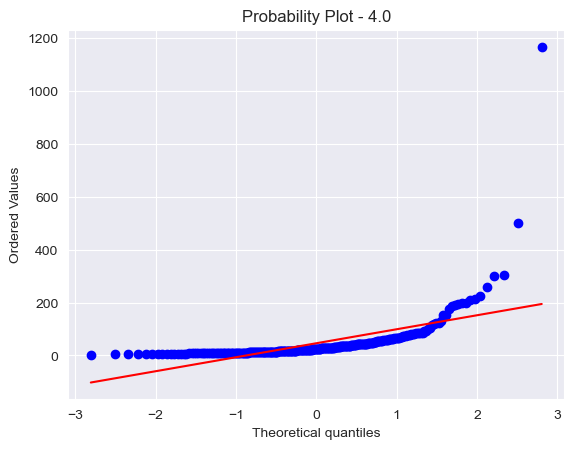

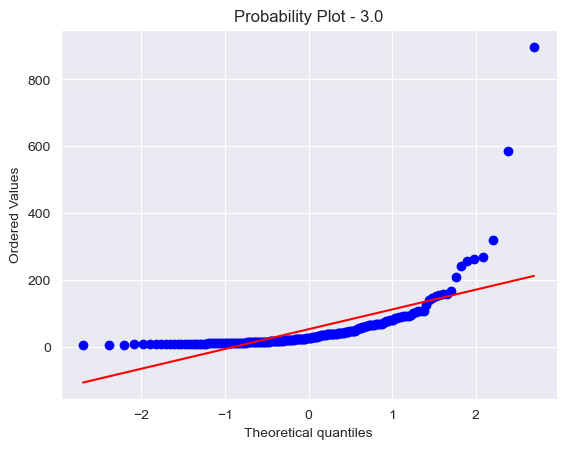

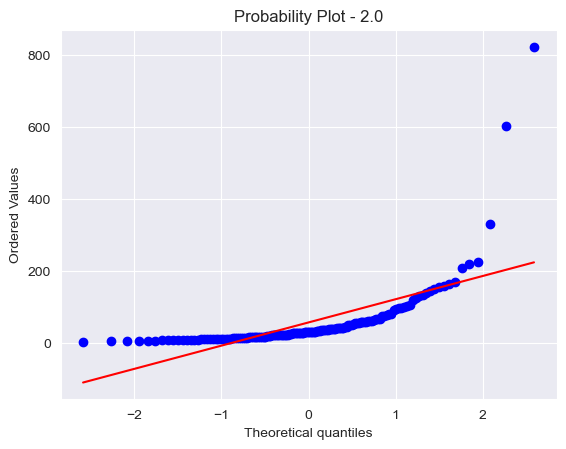

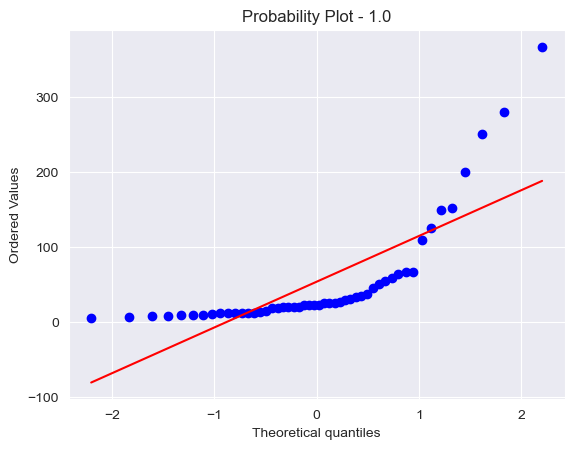

In [63]:
import scipy.stats as stats
import matplotlib.pyplot as plt

unique_ratings = sample_df['quality_rating'].unique()

for rating in unique_ratings:
    stats.probplot(sample_df[sample_df['quality_rating']==rating]['weekly_deaths'],dist="norm",plot=plt)
    plt.title("Probability Plot - " +  str(rating))
    plt.show()

### Homogeneity of Variance

Finally, to test the homogeneity of variance assumptions, I simply calculated the ratio of the max subset standard deviation to the min subset standard deviation. As shown, it is below 2, which means that we can go ahead and conduct the ANOVA test for significance on our sample.


In [64]:
ratio = sample_df.groupby('quality_rating').std().max() / sample_df.groupby('quality_rating').std().min()
ratio

weekly_deaths    1.299696
dtype: float64

### Constructing the model

Using the statsmodel package makes the construction of the ANOVA test very simple. The syntax is the same for an OLS, however the main difference is wrapping our independent variable with a c(), which just indicates that the independent variable is categorical and must be encoded accordingly.


In [65]:
anova_model = ols("weekly_deaths ~ C(quality_rating)", data = sample_df).fit()

### Results

After fitting the model, we can use the built in anova_lm method to display our metrics as a table. As we can see from the results, our p value of 0.72 at 4 degrees of freedom indicates that there is not enough evidence to conclude that there is a statistically significant difference in the mean deaths of nursing homes across different quality ratings. The size of the effect of our independent variable on our dependent variable is also not significant as well.


In [66]:
aov_table = sm.stats.anova_lm(anova_model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(quality_rating),1.783110e+04,4.0,0.526253,0.716472
Residual,8.428434e+06,995.0,NaN,NaN


## Conclusion

To conclude this analysis, all three methods of testing indicate that there is not enough evidence to reject the null hypothesis and conclude that there is either a linear relationship between quality survey scores and weekly deaths experienced by nursing homes, and also not enough evidence to conclude there is a significant difference in mean death rates between facilities of an overall categorical quality rating.The main areas for improvement in this analysis is to find a better technique for estimating the relationship of our variables. A multivariable regression is the next logical avenue for exploration, and even further down the line I would consider implementing some supervised machine learning techniques to build a model that can both estimate and explain the relationship between the variables chosen in this analysis. Further exploration is also needed in terms of the viability of normalizing the dependent variables for the invariant regressions conducted.  While it is unfortunate that no statistically significant results were yielded in this analysis, I still think the overall process was a valuable learning experience for me, and hope that subsequent explorations of alternative techniques yield feasible results.
